---
---
# Experiment: Regression on Compliance 
**AUTHOR:**   Athon Millane\
**DATE:** 25/04

---

### Contents
1. [Imports and data loading](#1)
2. [Global variables and hyperparameters](#2)
3. [Data processing pipeline](#3)
4. [SKLearn regression](#4)
5. [Feature contribution summary](#5)
6. [Visualising PCA](#6)
---

<a name="1"></a>
## 1. Imports and data loading 

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys; sys.path.append('../../src')
import pandas as pd
import matplotlib.pyplot as plt

from config import CURRENT, PROCESSED
from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, \
                             scale, melt, unmelt, remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap

---

<a name="2"></a>
## 2. Global variables and hyperparameters

In [3]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

# feature selection
DROP_X     = ['eotd_PEEP', 'ecmo_highest_PEEP_6hr_before', 
              'eotd_tidal_volume_ideal', 'eotd_tidal_volume_perkg', 'eotd_tidal_volume', 'ecmo_highest_tidal_volume_6hr_before', 
              'eotd_airway_plateau_pressure', 'ideal_weight', 'cause_of_death', 'ability_to_self_care','site_name','country']
SELECT_Y   = ['outcome']

---

<a name="3"></a>
## 3. Data processing pipeline

In [4]:
# Experimemt params
ICU_ONLY = True
DAY = None
Y   = 'outcome'

In [5]:
# processing
daily    = pd.read_csv(CURRENT/'daily.csv')
patients = pd.read_csv(CURRENT/'patients.csv')
patients_daily = daily.merge(patients, how='left', on='pin').set_index(['pin','date_daily']).sort_index()\
                      .reset_index().drop_duplicates(subset=['pin','date_daily']).set_index(['pin','date_daily'])\
                      .pipe(sort).pipe(replace_inf).pipe(drop_empty)
if DAY is not None:
    patients_daily = patients_daily[patients_daily['day'] == DAY]
    
if ICU_ONLY:
    patients_daily = patients_daily[patients_daily['day'] >= 0]

# numerical processing
patients_daily_num = patients_daily.pipe(select,'numerical').pipe(drop_by_nunique, 2)\
                                   .pipe(scale).pipe(remove_outliers).pipe(scale).pipe(sort).pipe(drop_empty)\
                                   .fillna(-1)

# categorical processing
patients_daily_binary = patients_daily_num.pipe(select,'numerical').pipe(drop_by_nunique, 1, 2)
patients_daily_cat = patients_daily.pipe(select, 'categorical').pipe(drop_by_nunique, 1)
patients_daily_cat = pd.merge(patients_daily_binary, patients_daily_cat, how='inner', left_index=True, right_index=True)
patients_daily_cat = patients_daily_cat.pipe(get_categories).pipe(filter_categorical, cutoff=20, plot=False)\
                                       .pipe(sort).fillna('other')
patients_daily_cat_oh = patients_daily_cat.pipe(onehot)

# merge numerical and categorical
processed = pd.merge(patients_daily_num.pipe(scale), patients_daily_cat_oh, left_index=True, right_index=True)
processed_X = processed.pipe(filter_regex, DROP_X+SELECT_Y)
processed_Y = processed.filter(regex='|'.join(SELECT_Y))
raw_Y = patients_daily.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(SELECT_Y))
df_y = raw_Y[SELECT_Y]



# specific to this particular experiment
# df_y = df_y[df_y > 0]

# match df_X and df_y
df_X, df_y = match(processed_X, df_y)

In [6]:
pd.set_option('display.max_columns', None)
# amir = df_y.pipe(onehot)
# processed.filter(regex='|'.join(SELECT_Y))
# amir

df_y['outcome'] = df_y['outcome'].replace('Death',1)
df_y['outcome'] = df_y['outcome'].replace('Discharged alive',2)
df_y['outcome'] = df_y['outcome'].replace('Hospitalization',2)
df_y['outcome'] = df_y['outcome'].replace('Transfer to other facility',2)
df_y['outcome'] = df_y['outcome'].replace('Palliative discharge',2)
df_y['outcome'] = df_y['outcome'].replace('Unknown',2)
# df_y

In [7]:
# merge numerical and categorical
processed_ = pd.merge(patients_daily_num.pipe(scale), patients_daily_cat, left_index=True, right_index=True)
processed_X_ = processed_.pipe(filter_regex, DROP_X+SELECT_Y)
processed_Y_ = processed_.filter(regex='|'.join(SELECT_Y))

# match df_X and df_y
df_X_,_ = match(processed_X_, df_y)

<a name="title"></a>
## THE QUESTION TO BE ANSWERED:
##    MORTALITY PREDICTOR 
## Death Vs. Discharged alive'Hospitalization,Transfer to other facility, etc

---

<a name="4"></a>
## 4. SKLearn Classification

In [8]:
import numpy as np
from utils.modelling import fit_cv_plot
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pylab as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


    
# fig,axs=plt.subplots(1,2,figsize=[12,6])
X, y = df_X, df_y

groups = np.array(X.reset_index()['pin'].tolist())
# print(groups.shape)

gss = GroupShuffleSplit(n_splits=10, train_size=0.8, random_state=42)
gss.get_n_splits()

cm = []
report = []
counter = 0
for train_idx, test_idx in gss.split(X, y, groups):
#     print("TRAIN:", train_idx, "TEST:", test_idx)
#     print("Length TRAIN:", len(train_idx), "Length TEST:", len(test_idx))
    counter = counter+1
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
#     print(np.unique(y_test))
    
    model =  RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight={1:3})
    # fit model on training data
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    cm_tmp = confusion_matrix(y_test, y_pred)
    print("\r\n"+"Confusion Matrix #"+str(counter))
    print(cm_tmp)
    cm.append(cm_tmp)
    cr = classification_report(y_test, y_pred)
    print("\r\n"+"Classification report")
    print(cr)
#     print("\r\n_________________________________________")
    accuracy = accuracy_score(y_test, y_pred)
    print("\r\n"+"Accuracy Score: %.2f%%" % (accuracy * 100.0))
    print("\r\n_________________________________________")



print("\r\n"+"Confution Matrix mean ")
print(np.round(np.mean(cm, axis=0)))




Confusion Matrix #1
[[201  64]
 [112 672]]

Classification report
              precision    recall  f1-score   support

           1       0.64      0.76      0.70       265
           2       0.91      0.86      0.88       784

    accuracy                           0.83      1049
   macro avg       0.78      0.81      0.79      1049
weighted avg       0.84      0.83      0.84      1049


Accuracy Score: 83.22%

_________________________________________

Confusion Matrix #2
[[189 131]
 [ 69 716]]

Classification report
              precision    recall  f1-score   support

           1       0.73      0.59      0.65       320
           2       0.85      0.91      0.88       785

    accuracy                           0.82      1105
   macro avg       0.79      0.75      0.77      1105
weighted avg       0.81      0.82      0.81      1105


Accuracy Score: 81.90%

_________________________________________

Confusion Matrix #3
[[211 151]
 [ 59 648]]

Classification report
           

In [38]:
np.unique(y_train)
len(y_train)

4420

Confusion matrix:
    https://en.wikipedia.org/wiki/Confusion_matrix
    https://www.youtube.com/watch?time_continue=599&v=FAr2GmWNbT0&feature=emb_logo
        
TP =(i,i)
FN = sum of values in rows excluding TP
FP = sume of value is columns excluding TP

More info:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise. See also precision_recall_fscore_support for more details on averages.

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

f1 =2*((precision*recall)/(precision+recall)) - If we were looking to select a model based on a balance between precision and recall, the F1 measure suggests that All Recurrence model is the one to beat and that CART model is not yet sufficiently competitive.https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

In [10]:
pd.set_option('display.max_columns', None)


<a name="5"></a>
## 5. SHAP: Build a Tree-Based Model

In [18]:
import xgboost
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X,y = df_X, df_y
groups = np.array(X.reset_index()['pin'].tolist())
# print(groups.shape)

gss = GroupShuffleSplit(n_splits=10, train_size=0.8, random_state=42)
gss.get_n_splits()
acc = -100000

for train_idx, test_idx in gss.split(X, y, groups):
#     print("TRAIN:", train_idx, "TEST:", test_idx)
#     print("Length TRAIN:", len(train_idx), "Length TEST:", len(test_idx))
    counter = counter+1
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    gss = GroupShuffleSplit(n_splits=10, train_size=0.8, random_state=42)
    gss.get_n_splits()


    model = XGBClassifier(objective='binary:logistic')
    # fit model on training data
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    # print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # store the best accuracy and data 
    if accuracy > acc:
        acc = accuracy
        X_train1 = X_train
        X_test1 = X_test
        y_train1 = y_train
        y_test1 =y_test
        model1 = model
        

print("Accuracy: %.2f%%" % (acc * 100.0))

X_train = X_train1
X_test = X_test1
y_train = y_train1
y_test = y_test1
model = model1


Accuracy: 84.68%


<a name="5.1"></a>
## 5.1. SHAP: Init

In [46]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

<a name="5.1"></a>
## 5.1. SHAP: Feature Importance (Global Interpretability)

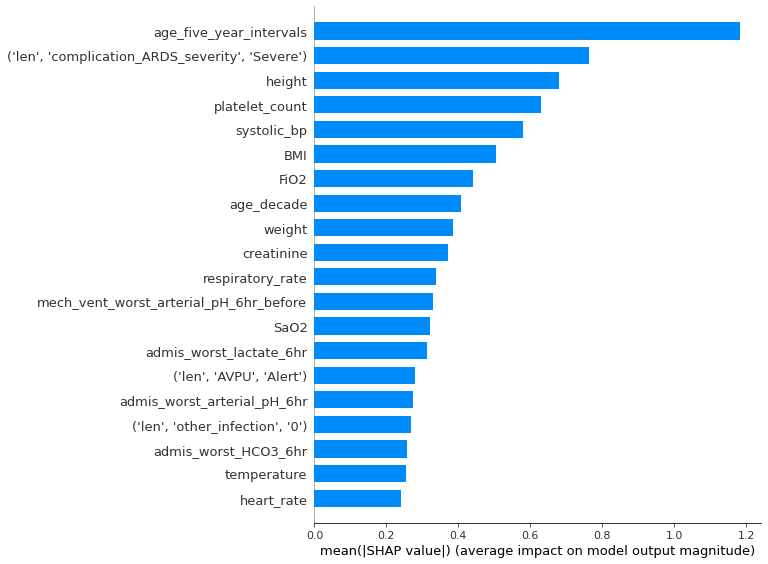

In [48]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

<a name="5.3"></a>
## 5.3. Feature Importance — Local Interpretability

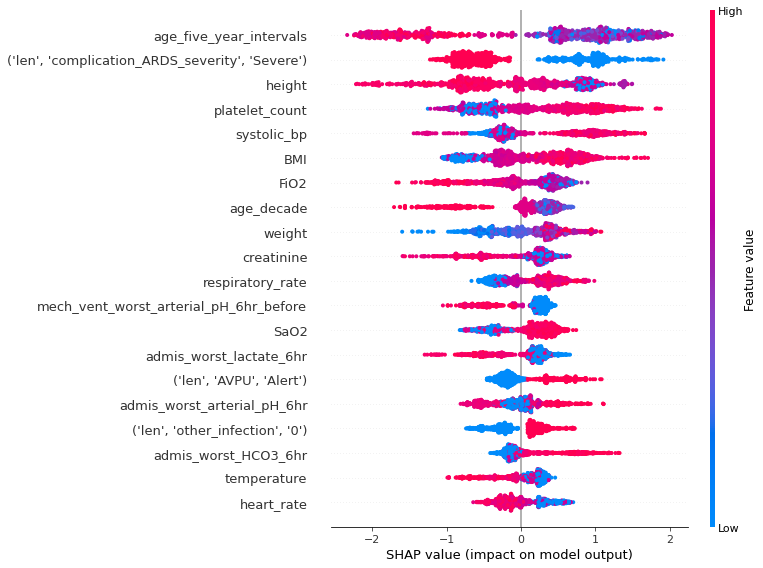

In [47]:
shap.summary_plot(shap_values, X_test)

Feature importance: Variables are ranked in descending order.
Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
Correlation: A high level of the “age_five_year_interval” content has a high and positive impact on the Death outcome. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “temprature” is negatively correlated with the target variable.

<a name="5.5"></a>
## 5.5. SHAP: Dependency Plot'  

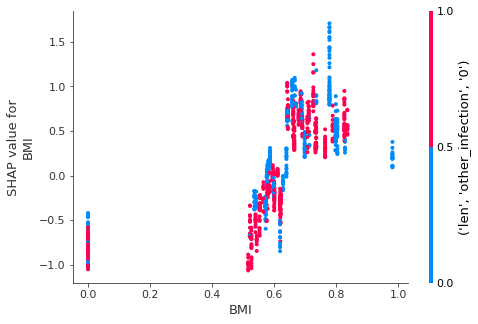

In [49]:
shap.dependence_plot("BMI", shap_values, X_test)

---

<a name="5"></a>
## 5. Feature contribution summary

In [16]:
import seaborn as sns

def colour(df, n=10, cm=None):
    """Plot df in glorious technicolor.
    """
    if not cm:
        cm = sns.light_palette("green", as_cmap=True)
    display(df.head(n).style.background_gradient(cmap=cm))
    return df

def get_importance(df_X,results):
    """Return table of most important features according to different metrics.
    """
    importances = ([e.feature_importances_ for e in results['estimator']])
    features = df_X.columns.to_frame(name='feature').reset_index(drop=True)
    for i in range(len(importances)):
        features[f'importance_cv{i+1}'] = importances[i]
    features['importance_mean'] = features.filter(regex='importance').mean(axis=1)
    return features.sort_values(by='importance_mean',ascending=False)

def features_subset(features_in):
    """Return sorted list of features by importance.
    """
    features = features_in.copy()
    features['feature'] = features['feature'].apply(lambda x: x[1] if type(x) == tuple else x)
    return features.groupby(['feature'])['importance_mean'].sum().sort_values(ascending=False).to_frame(name='Feature Contribution')

In [17]:
importances = get_importance(df_X, results['Random Forest']).pipe(colour)
features = features_subset(importances).pipe(colour)

NameError: name 'results' is not defined

### Iterate (Recursive feature elimination)

In [ ]:
subset = importances.head(10)['feature'].tolist()
ests = [('Random Forest', RandomForestRegressor(n_estimators=200,
                                                max_depth=10,
                                                random_state=42)),
        ('GBDT', GradientBoostingRegressor(n_estimators=2000,
                                           max_depth=10))]
fig,axs=plt.subplots(1,2,figsize=[12,6])
results_ = fit_cv_plot(df_X[subset], df_y[Y].values, axs, ests)
importances_ = get_importance(df_X[subset], results_['Random Forest'])
top_features = features_subset(importances_).pipe(colour)

In [ ]:
def pps_plot(df, cluster=False):
    import ppscore as pps
    import seaborn as sns
    pps.CV_ITERATIONS = 10
    df_matrix = pps.matrix(df)
    if cluster:
        _=sns.clustermap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, dendrogram_ratio=(0.2,0.2))
    else:
        fig,ax=plt.subplots(1,1,figsize=[8,6])
        sns.heatmap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True).set_title('Predictive Power Score')
        ax.set_xlabel('Feature'); ax.set_ylabel('Target')

df_pps = df_X_[features_subset(importances_).index.tolist()].merge(df_y[Y], left_index=True, right_index=True)
df_pps.pipe(pps_plot)
df_pps.pipe(pps_plot, cluster=True)

---

#### Compliance vs top features

In [ ]:
top_features

In [ ]:
compliance = pd.read_csv(PROCESSED/'first_crs.csv')
compliance_ = compliance[['pin']].merge(patients_daily.pipe(select,'numerical').pipe(remove_outliers, lower_quantile=0.01, upper_quantile=0.94).reset_index(), 
                                        how='left', left_on='pin', right_on='pin')[top_features.head(5).index.tolist()+[Y]]

In [ ]:
sns.set_palette("muted")

compliance_['Compliance Bin'] = pd.cut(compliance_.compliance_respiratory_system,bins=[0,30,50,100],labels=['Low (<30)','Medium (30-50)','High (>50)'])
with sns.axes_style("dark"):
    _=sns.pairplot(compliance_.drop('compliance_respiratory_system', axis=1), hue='Compliance Bin', kind="reg", height=2, plot_kws=dict(scatter_kws=dict(s=2)))

In [ ]:
comp = compliance_.drop('Compliance Bin', axis=1).melt(id_vars='compliance_respiratory_system')

with sns.axes_style("dark"):
    g = sns.FacetGrid(comp, hue="variable", col="variable", col_wrap=5, height=4, sharex=False, sharey=False)
g.map(sns.kdeplot, "compliance_respiratory_system", "value", shade=True, n_levels=5);

In [ ]:
sns.lmplot('value','compliance_respiratory_system',comp,hue="variable",col="variable",col_wrap=5,height=4,sharex=False,sharey=False,scatter_kws={"s": 5})

---

<a name="6"></a>
## 6. Visualising PCA 

In [ ]:
from utils.manifold import summary
sns.set_palette("coolwarm")
pd.merge(df_X, df_y[[Y]].pipe(scale), left_index=True, right_index=True).pipe(summary, exps=['PCA'], labels=df_y[[Y]]).pipe(cap)

In [ ]:
from utils.explanations import pca_explain, get_pc
summary = pd.merge(df_X, df_y.pipe(scale), left_index=True, right_index=True).pipe(get_pc)[['feature','pc_0_abs','pc_1_abs']]
summary['sum_abs_pc'] = summary['pc_0_abs'] + summary['pc_1_abs']
summary.sort_values('pc_0_abs',ascending=False).head(10).pipe(colour)
summary.sort_values('pc_1_abs',ascending=False).head(10).pipe(colour)
summary.sort_values('sum_abs_pc',ascending=False).head(10).pipe(colour)

---
---